## Multivariate Time Series Forecasting with Deep Learning
### Predicting the price of Bitcoin and interpreting the results

This notebook runs the entire forecasting pipeline from data preparation to model training and interpretation.

Alternatively, everything can be run from the terminal as well (see README.md).

Prerequisite: Dataset has been downloaded (see README.md) and parameters have been updated if necessary (see /model/params.yaml).

### Setup

In [1]:
import os
import yaml
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

os.chdir("../scripts")

import preprocess, train, inference, interpret

In [2]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']

### Load and Prepare the Data

In [3]:
file_name = "BATS_TSLA_tradingView_closePriceNLabel.csv"
data = preprocess.load_data(file_name)
data.head(3)

,Close,Label
0,15.877984,-1
1,16.167317,-1
2,16.209984,1


In [4]:
train_df, test_df = preprocess.prep_data(df=data, train_frac=0.8, plot_df=True)
train_df.head(20)

Starting with data preparation...
           Close  Label
0      15.877984     -1
1      16.167317     -1
2      16.209984      1
3      16.999316      1
4      17.381316      1
...          ...    ...
1931  185.000000     -1
1932  187.040000     -1
1933  184.310000     -1
1934  180.590000     -1
1935  162.990000     -1

[1936 rows x 2 columns]
Completed.


,Close,Label
0,0.022122,-1
1,0.023138,-1
2,0.023288,1
3,0.026059,1
4,0.027401,1
5,0.026120,1
6,0.023061,1
7,0.020390,-1
8,0.017604,-1
9,0.017875,-1


In [5]:
train_df.shape, test_df.shape

((1548, 2), (388, 2))

### Explore the Data

In [6]:
plot_df = pd.read_csv(Path(data_dir, 'plot_df.csv'))
plot_df['Close_Change'] = plot_df.Close.pct_change(1)
plot_df = plot_df.dropna()

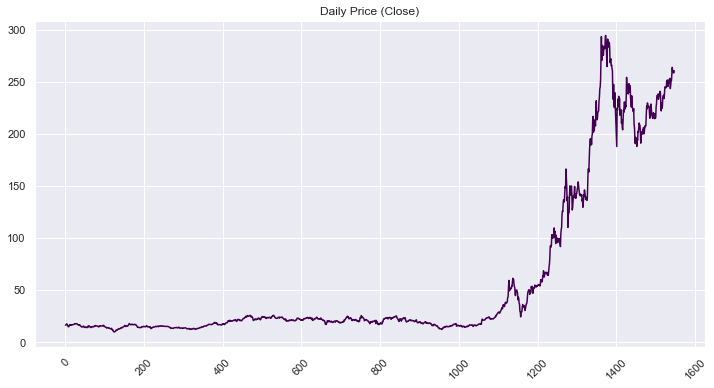

In [7]:
plot_df['Close'].plot(figsize=(12,6), rot=45, cmap='viridis')
plt.title('Daily Price (Close)')
plt.show()

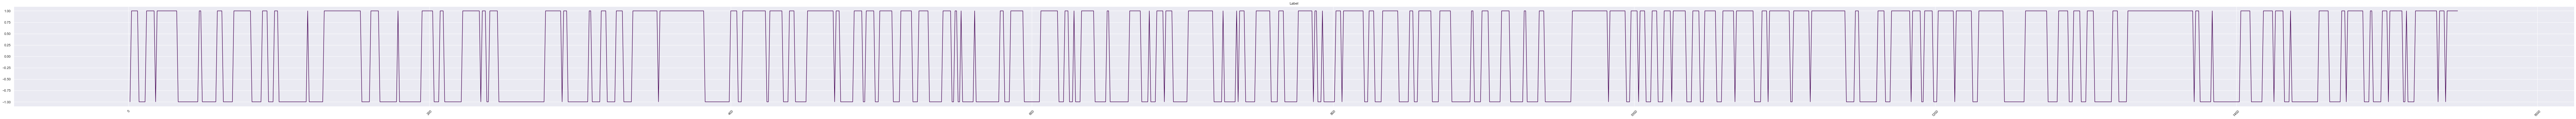

In [8]:
plot_df['Label'].plot(figsize=(150,6), rot=45, cmap='viridis')
plt.title('Label')
plt.show()

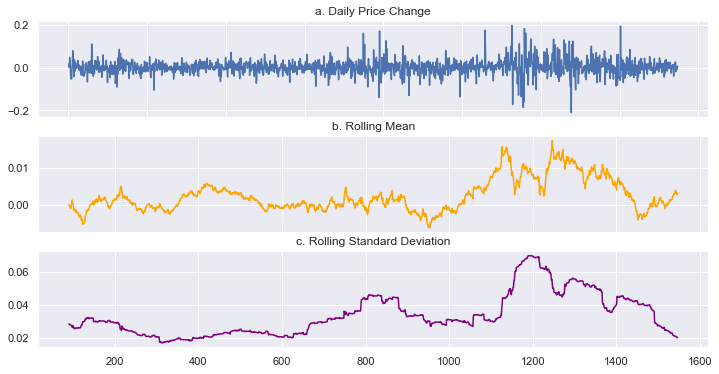

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_df['Close_Change'].plot(ax=axes[0], figsize=(12,6), rot=90, title='a. Daily Price Change', sharex=True)
plot_df['Close_Change'].rolling(90).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
plot_df['Close_Change'].rolling(90).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

### Train the LSTM model

In [10]:
sequence_length = 30
batch_size = 8
n_epochs = 20
n_epochs_stop = 5
label_name = 'Label'

In [11]:
print(train_df, test_df)
hist = train.train_model(train_df, test_df, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)

         Close  Label
0     0.022122     -1
1     0.023138     -1
2     0.023288      1
3     0.026059      1
4     0.027401      1
...        ...    ...
1543  0.876480      1
1544  0.880869      1
1545  0.874045      1
1546  0.873741      1
1547  0.881127      1

[1548 rows x 2 columns]          Close  Label
1548  0.880027      1
1549  0.882555      1
1550  0.895266      1
1551  0.885762      1
1552  0.893311      1
...        ...    ...
1931  0.615980     -1
1932  0.623144     -1
1933  0.613558     -1
1934  0.600495     -1
1935  0.538694     -1

[388 rows x 2 columns]
Starting with model training...
Epoch 1 train loss: 0.7763 test loss: 0.5705
Epoch 2 train loss: 0.5446 test loss: 0.547
Epoch 3 train loss: 0.5384 test loss: 0.5432
Epoch 4 train loss: 0.5315 test loss: 0.5396
Epoch 5 train loss: 0.5192 test loss: 0.5394
Epoch 6 train loss: 0.515 test loss: 0.5381
Epoch 7 train loss: 0.5199 test loss: 0.5366
Epoch 8 train loss: 0.5236 test loss: 0.5354
Epoch 9 train loss: 0.5147 test l

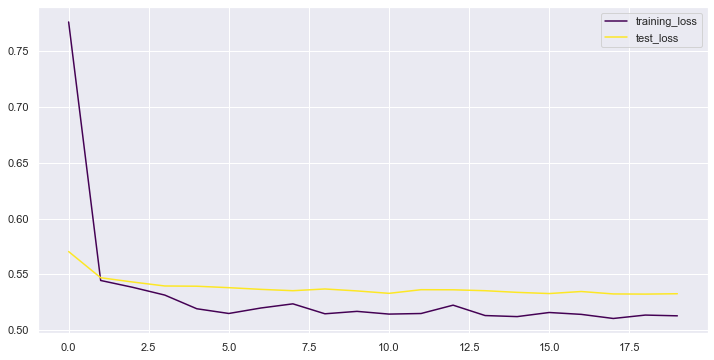

In [12]:
hist.plot(figsize=(12,6), cmap='viridis')
plt.show()

### Evaluate the model

In [13]:
predictions, labels = inference.predict(df=test_df,
                                                          label_name='Label',
                                                          sequence_length=sequence_length)

predictions, labels
predictions_descaled = predictions
labels_descaled = labels

In [14]:
print('Error on all test data:')
inference.print_loss_metrics(labels_descaled, predictions_descaled)
print('\n')
print('Error on partial test data:')
inference.print_loss_metrics(labels_descaled[:30], predictions_descaled[:30])

Error on all test data:
RMSE:  0.74
MAE:  0.53


Error on partial test data:
RMSE:  0.82
MAE:  0.61


In [15]:
prediction_Classification = inference.accuracyByClassifying(labels,predictions)

Classification Accuracy: 83.24022346368714


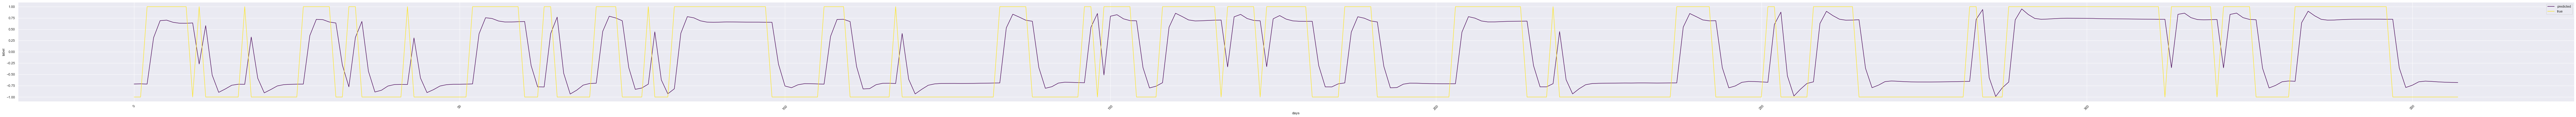

In [16]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled
df_pred['true'] = labels_descaled
# df_pred['residual'] = labels_descaled - predictions_descaled
df_pred.plot(figsize=(150,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('label')
plt.legend()
plt.show()

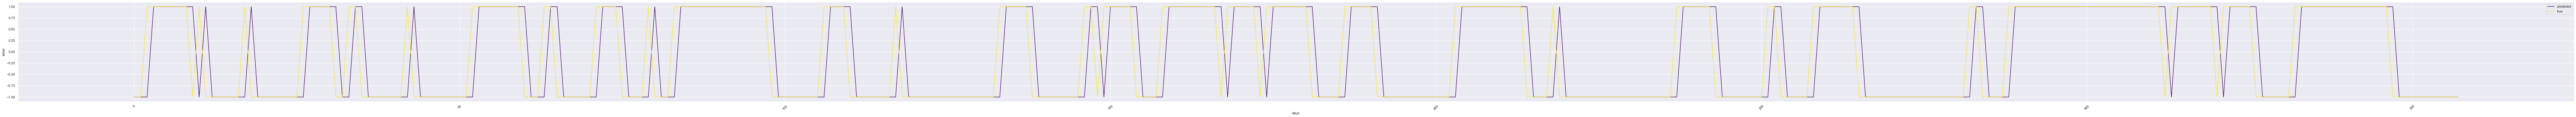

In [17]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = prediction_Classification
df_pred['true'] = labels_descaled
# df_pred['residual'] = labels_descaled - predictions_descaled
df_pred.plot(figsize=(150,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('label')
plt.legend()
plt.show()

### Find important features

In [18]:
from train import TimeSeriesDataset, TSModel
from torch.utils.data import DataLoader
import torch
import shap

In [19]:
background_data_size = 900
test_sample_size = 100
sequence_length = 30

In [20]:
shap_values = interpret.get_important_features(
    background_data_size,
    test_sample_size,
    sequence_length
)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [21]:
shap_plot = pd.DataFrame(shap_values, columns=train_df.columns.tolist())
shap_plot['days'] = [i-31 for i in list(range(1,31))]
shap_plot.head()

,Close,Label,days
0,1.979238e-09,2.111788e-09,-30
1,4.624870e-09,4.687800e-09,-29
2,8.964572e-09,8.535342e-09,-28
3,1.661489e-08,1.673679e-08,-27
4,2.929609e-08,3.254236e-08,-26


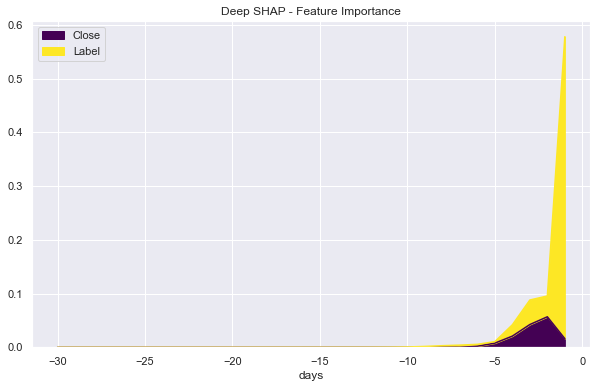

In [22]:
shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()